<font size="+3"><strong>Gradient Boosting Trees</strong></font>

We'll start this notebook the same way we've started the others: preparing the data and building our model, and this time with a new ensemble model. Once it's working, we'll learn some new performance metrics to evaluate it.

In [ ]:
# Import libraries
import json
import pickle

import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

# **Prepare Data**


## **Import**

In [ ]:
def wrangle(filename):
    with open (filename, "r") as f:
             data = json.load(f)

    df = pd.DataFrame().from_dict(data["data"]).set_index("id")

    return df

In [ ]:
df = wrangle("taiwan-bankruptcy-data.json")
print(df.shape)
df.head()

(6819, 96)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95,bankrupt
id,,,,,,,,,,,,,,,,,,,,,
1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,True
2,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,True
3,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474,True
4,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982,True
5,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490,True


## **Split**

In [ ]:
# Create our feature matrix X and target vector y. Our target is "bankrupt"

target = "bankrupt"
X = df.drop(columns = target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6819, 95)
y shape: (6819,)


In [ ]:
# Divide our data (X and y) into training and test sets using a randomized train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5455, 95)
y_train shape: (5455,)
X_test shape: (1364, 95)
y_test shape: (1364,)


## **Resample**

In [ ]:
# Create a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on the training data

over_sampler = RandomOverSampler(random_state= 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (10572, 95)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
0,0.498513,0.542848,0.544622,0.599194,0.599036,0.998986,0.797412,0.809330,0.303528,0.781593,...,0.801313,0.005821,0.623649,0.599196,0.840580,0.282564,0.027239,0.566658,1,0.022512
1,0.506606,0.562309,0.558863,0.609334,0.609334,0.999027,0.797450,0.809375,0.303508,0.781637,...,0.810914,0.000481,0.623932,0.609332,0.841339,0.280570,0.026843,0.565395,1,0.026670
2,0.508799,0.561001,0.554687,0.614242,0.614055,0.999094,0.797533,0.809424,0.303514,0.781692,...,0.809740,0.001397,0.623714,0.614241,0.840969,0.277772,0.026864,0.565484,1,0.041556
3,0.499976,0.562527,0.546764,0.597825,0.597825,0.999004,0.797411,0.809329,0.303490,0.781590,...,0.810082,0.000998,0.623986,0.597824,0.841885,0.286871,0.026951,0.565820,1,0.018173
4,0.477892,0.547700,0.529150,0.600362,0.600362,0.998975,0.797412,0.809333,0.303551,0.781584,...,0.804638,0.002826,0.623845,0.600363,0.840885,0.282073,0.026959,0.565848,1,0.023328


# **Build Model**

Now let's put together our model. We'll start by calculating the baseline accuracy, just like we did last time.

## **Baseline**

In [ ]:
# Calculate the baseline accuracy score for our model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.969


## **Iterate**

Even though the building blocks are the same, here's where we start working with something new. First, we're going to use a new type of ensemble model for our classifier.

In [ ]:
# Create a pipeline named clf (short for "classifier") that contains a SimpleImputer transformer and a GradientBoostingClassifier predictor

clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier())

In [ ]:
"""
Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier.

        1. For the SimpleImputer, try both the "mean" and "median" strategies.
        2. For the GradientBoostingClassifier, try max_depth settings between 2 and 5.
        3. Also for the GradientBoostingClassifier, try n_estimators settings between 20 and 31, by steps of 5.
"""

params = {
    "simpleimputer__strategy":["mean","median"],
    "gradientboostingclassifier__n_estimators":range(20, 31, 5),
    "gradientboostingclassifier__max_depth":range(2,5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

In [ ]:
# Create a GridSearchCV named model that includes our classifier and hyperparameter grid

model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
# Fit our model to the over-sampled training data
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
# Extract the cross-validation results from model and load them into a DataFrame named cv_results
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,12.390968,1.367263,0.017794,0.000243,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.963121,0.964066,0.964522,0.966414,0.971618,0.965948,0.003031,1
16,14.360598,1.976319,0.028737,0.009107,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.962648,0.964066,0.964522,0.966887,0.971145,0.965854,0.002977,2
15,10.044019,0.641314,0.026012,0.010899,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.961702,0.963121,0.962157,0.964995,0.969726,0.964340,0.002920,3
14,9.899324,0.729622,0.018133,0.000616,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.961229,0.962175,0.962157,0.964995,0.969726,0.964056,0.003104,4
12,7.784691,0.714199,0.017387,0.000584,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.956974,0.958865,0.957900,0.961211,0.967360,0.960462,0.003726,5
13,8.291428,0.541630,0.025889,0.010717,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.957447,0.958392,0.957900,0.960738,0.967360,0.960367,0.003676,6
11,9.484930,0.445399,0.022606,0.009676,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.945154,0.948936,0.950804,0.946547,0.945601,0.947408,0.002143,7
10,9.866864,1.325085,0.023457,0.007240,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.945154,0.948936,0.950804,0.946547,0.945601,0.947408,0.002143,7
9,8.666364,0.366652,0.022824,0.009018,3,25,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.939007,0.942317,0.932829,0.942763,0.942763,0.939936,0.003822,9
8,9.530305,0.794861,0.024988,0.009552,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.939007,0.942317,0.932829,0.942763,0.942763,0.939936,0.003822,9


There are quite a few hyperparameters there, so let's pull out the ones that work best for our model.

In [ ]:
# Extract the best hyperparameters from model
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'median'}

## **Evaluate**

Now that we have a working model that's actually giving us something useful, let's see how good it really is.


In [ ]:
# Calculate the training and test accuracy scores for model
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9714
Validation Accuracy: 0.9267


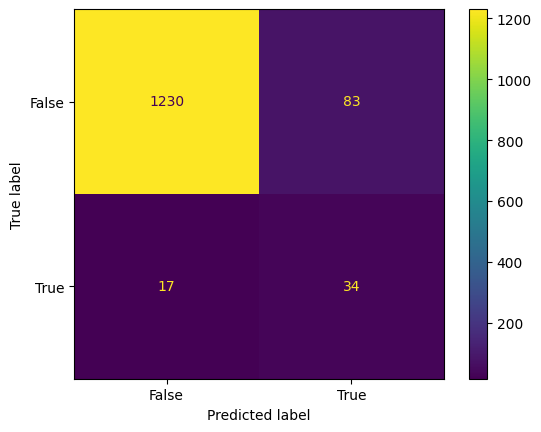

In [ ]:
# Plot a confusion matrix that shows the best model performs on test set
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [ ]:
# Print the classification report for our model, using the test set
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.94      0.96      1313
        True       0.29      0.67      0.40        51

    accuracy                           0.93      1364
   macro avg       0.64      0.80      0.68      1364
weighted avg       0.96      0.93      0.94      1364



# **Communicate**

In [ ]:
# Save our best-performing model to a file named "model-3.pkl
with open("model-3.pkl", "wb") as f:
     pickle.dump(model, f)

In [ ]:
# Add make_predictions function from notebook 3
def make_predictions(data_filepath, model_filepath):
    """
    The function takes the name of a decompressed file as input and returns a tidy DataFrame

    Parameters
    ----------

    data_filepath : str
       the path of a JSON file that contains test data

    model_filepath : str
       the path of a serialized model

    Returns
    -------
    predictions : series

    """

    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath, "rb") as f:
           model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index = X_test.index, name = "bankrupt")
    return y_test_pred

In [ ]:
# Generate predictions
y_test_pred = make_predictions(
    data_filepath="taiwan-bankruptcy-data-test-features.json",
    model_filepath="model-3.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (682,)


id
18    False
20    False
24     True
32     True
38    False
Name: bankrupt, dtype: object